In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_curve, auc, precision_recall_curve)

In [2]:
# Load test dataset
df_test = pd.read_parquet("../data/final/test_data.parquet")

# Drop classification target to avoid leakage
df_test = df_test.drop(columns=['DepDelayMinutes'])

# Extract features and target
X_test = df_test.drop(columns=['DepDel15'])
y_test = df_test['DepDel15'].values.ravel()

In [3]:
# Regression models
classification_models = {
    "Logistic Regression": "../models/logistic_regression/logistic_regression_base.pkl",
    "SGD Classifier": "../models/sgd_classifier/sgd_classifier_base.pkl",
    "HistGradientBoosting Classifier": "../models/histgradientboosting_classifier/histgradientboosting_classifier_base.pkl"
}

In [4]:
# Storage for results
classification_results = []
model_predictions = {}

# Load models and evaluate
for model_name, file in classification_models.items():
    with open(file, "rb") as f:
        model = pickle.load(f)
    
    y_pred = model.predict(X_test)
    model_predictions[model_name] = y_pred
    
    if hasattr(model, "predict_proba"):  # Probabilistic classifiers
        y_proba = model.predict_proba(X_test)[:, 1]  
        model_predictions[model_name + " Prob"] = y_proba
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

    classification_results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Convert to DataFrame and display
df_classification = pd.DataFrame(classification_results)

In [5]:
df_classification

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.620765,0.628519,0.607542,0.617852
1,SGD Classifier,0.580280,0.556970,0.822339,0.664127
2,HistGradientBoosting Classifier,0.662029,0.677308,0.630735,0.653192


<Figure size 1000x600 with 0 Axes>

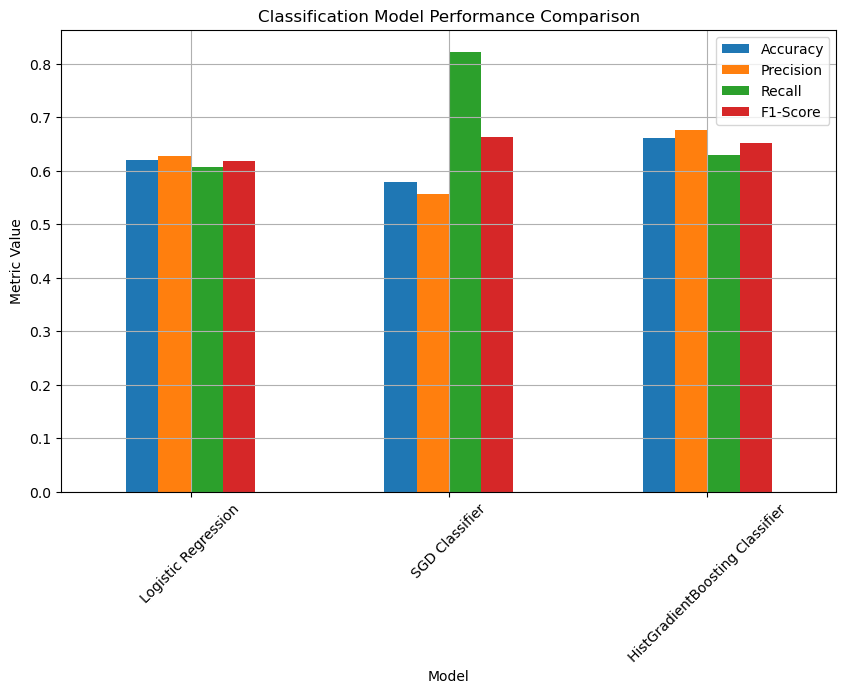

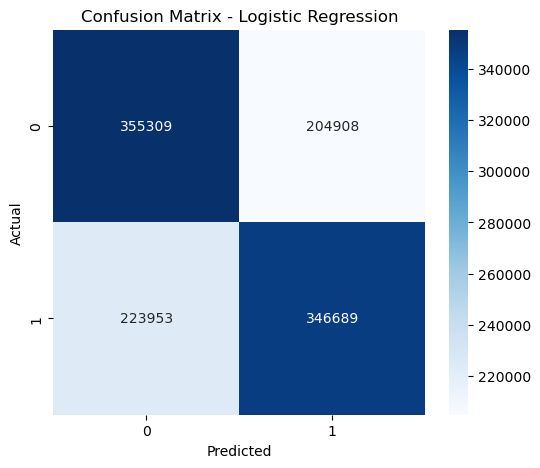

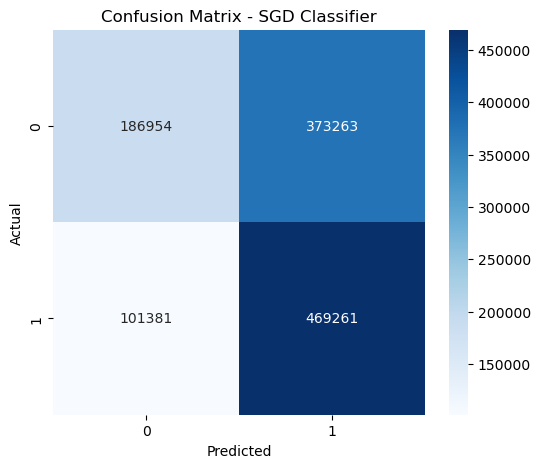

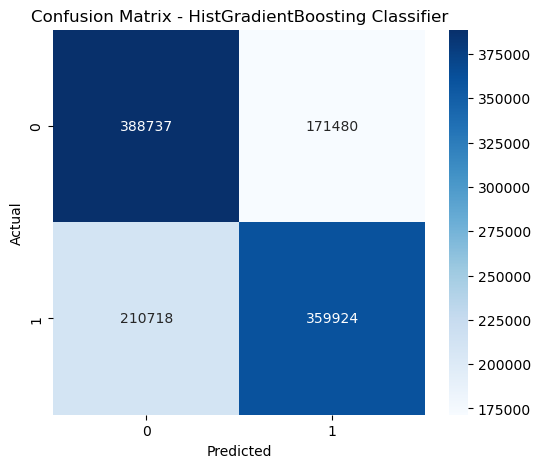

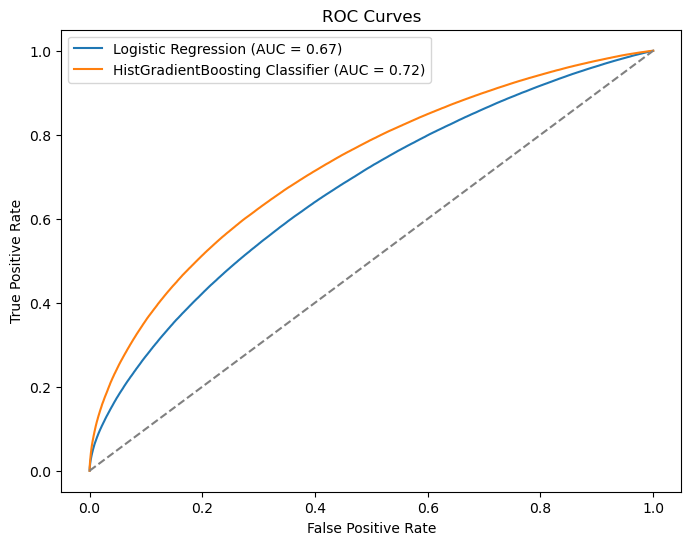

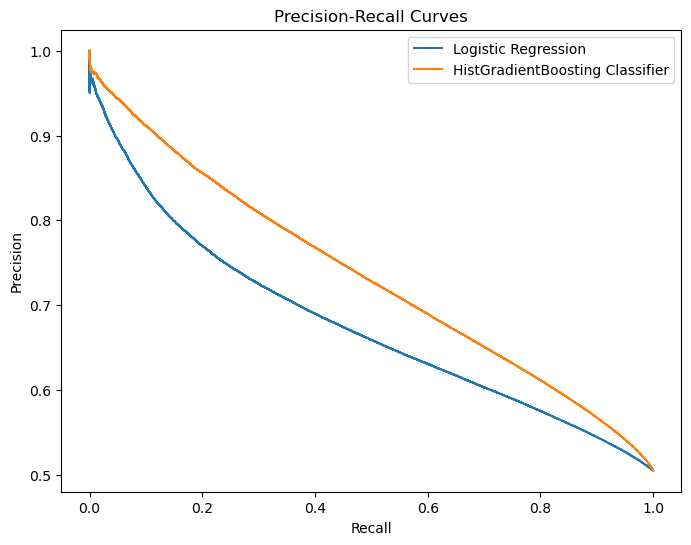

In [6]:
# --- Visualization ---

# 1. Classification Performance Bar Plot
plt.figure(figsize=(10, 6))
df_classification.set_index("Model").plot(kind="bar", figsize=(10, 6))
plt.title("Classification Model Performance Comparison")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# 2. Confusion Matrices
for model_name in classification_models.keys():
    cm = confusion_matrix(y_test, model_predictions[model_name])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# 3. ROC Curve
plt.figure(figsize=(8, 6))
for model_name in classification_models.keys():
    if model_name + " Prob" in model_predictions:
        fpr, tpr, _ = roc_curve(y_test, model_predictions[model_name + " Prob"])
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# 4. Precision-Recall Curve
plt.figure(figsize=(8, 6))
for model_name in classification_models.keys():
    if model_name + " Prob" in model_predictions:
        precision, recall, _ = precision_recall_curve(y_test, model_predictions[model_name + " Prob"])
        plt.plot(recall, precision, label=model_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()